In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


import library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
from nltk.corpus import wordnet
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
import pickle

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
import pandas as pd

backtranslate = '/content/drive/MyDrive/deeplearningProgression/backtranslate.csv'
backtranslate = pd.read_csv(backtranslate)

huggingFace_dataset = '/content/drive/MyDrive/deeplearningProgression/huggingface_dataset.csv'
huggingFace_dataset = pd.read_csv(huggingFace_dataset)


print(backtranslate.head())
print(huggingFace_dataset.head())

                                               title  \
0  law enforcement high alert following threat co...   
1                                            missing   
2  unbelievable obamas attorney general say charl...   
3  bobby jindal raised hindu us story christian c...   
4  satan 2 russia unvelis image terrifying new su...   

                                                text  label  title_missing  \
0  comment expected barack obama member fyf911 fu...      1          False   
1                          post vote hillary already      1           True   
2  demonstrator gathered last night exercising co...      1          False   
3  dozen politically active pastor came private d...      0          False   
4  rs28 sarmat missile dubbed satan 2 replace ss1...      1          False   

   text_missing                                       title_tokens  \
0         False  ['law', 'enforcement', 'high', 'alert', 'follo...   
1         False                                       

In [6]:
# Preprocessing Kaggle dataset for training
x_train = backtranslate['back_translated_text'].values.tolist()  # Using the cleaned text data
y_train = backtranslate['label'].values  # Labels

# Preprocessing HuggingFace dataset for testing
x_test = huggingFace_dataset['news_tokens'].values.tolist()
y_test = huggingFace_dataset['label'].values

# Display the length of the combined dataset
print(f"Length of combined dataset (back translate): {len(x_train)}")

Length of combined dataset (back translate): 29995


Tokenization and padding

In [12]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure all values in x_train are strings and handle NaN values
x_train = [str(text) if not pd.isnull(text) else "" for text in x_train]
x_test = [str(text) if not pd.isnull(text) else "" for text in x_test]

# Tokenization and padding
total_words = 10000  # Limit to top 10,000 words
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(x_train)

# Save the tokenizer for later use in the Streamlit app
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Convert texts to sequences of integers
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# Padding sequences to ensure uniform length
max_len_of_news = 200  # Set a fixed length for padding
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_len_of_news, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_len_of_news, padding='post', truncating='post')

# Confirm that the data is padded and tokenized correctly
print(f"x_train_padded shape: {x_train_padded.shape}")
print(f"x_test_padded shape: {x_test_padded.shape}")


x_train_padded shape: (29995, 200)
x_test_padded shape: (21318, 200)


model architecture

In [13]:
# Define the model with tuned hyperparameters and regularization
model = Sequential()
model.add(Input(shape=(max_len_of_news,)))

# Increased embedding dimensions and LSTM units
model.add(Embedding(input_dim=total_words, output_dim=128))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))  # Increased dropout for better regularization
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))

# Added L2 regularization to dense layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation="sigmoid"))  # Sigmoid for binary classification

# Compile the model with a lower learning rate
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,502,465 (5.73 MB)

 Trainable params: 1,502,465 (5.73 MB)

 Non-trainable params: 0 (0.00 B)

trainning

In [18]:
# Create callbacks for early stopping and model checkpoint
checkpoint = ModelCheckpoint(filepath='model_weights_epoch_{epoch:02d}.weights.h5',
                             save_weights_only=True, save_freq=5*len(x_train) // 50)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model with a smaller batch size
history = model.fit(x_train_padded, y_train,
                    epochs=20,
                    batch_size=32,  # Decreased batch size for better generalization
                    validation_split=0.1,
                    callbacks=[checkpoint, early_stop])

Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.9505 - loss: 0.1721 - val_accuracy: 0.9233 - val_loss: 0.2268
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9716 - loss: 0.1102 - val_accuracy: 0.9237 - val_loss: 0.2414
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.9737 - loss: 0.0992 - val_accuracy: 0.9193 - val_loss: 0.2695
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9817 - loss: 0.0746 - val_accuracy: 0.9150 - val_loss: 0.2839
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.9887 - loss: 0.0533 - val_accuracy: 0.9193 - val_loss: 0.3437
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.9910 - loss: 0.0484 - val_accuracy: 0.9170 - val_loss: 0.3904
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.9945 - loss: 0.0342 - val_accuracy: 0.9057 - val_loss: 0.3542
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.9891 - loss: 0.0501 - 

save the model & evalution

In [22]:
# Save the entire model after training is complete for use in the Streamlit app
model.save('model3.h5')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test_padded, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Predict the labels for the test data
y_pred = model.predict(x_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Print the classification report
print(classification_report(y_test, y_pred_classes, target_names=['Fake', 'Real']))

667/667 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.3189 - loss: 2.5489
Test Loss: 2.1395621299743652
Test Accuracy: 0.43029364943504333
667/667 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00     12145
        Real       0.43      1.00      0.60      9173

    accuracy                           0.43     21318
   macro avg       0.22      0.50      0.30     21318
weighted avg       0.19      0.43      0.26     21318



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


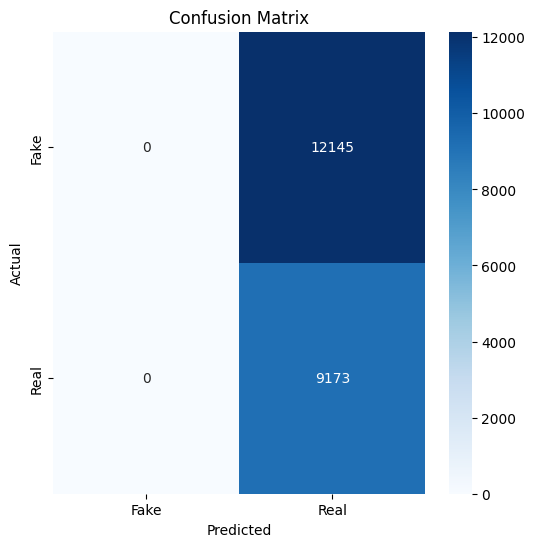

In [20]:
# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Text(0, 0.5, 'Loss')

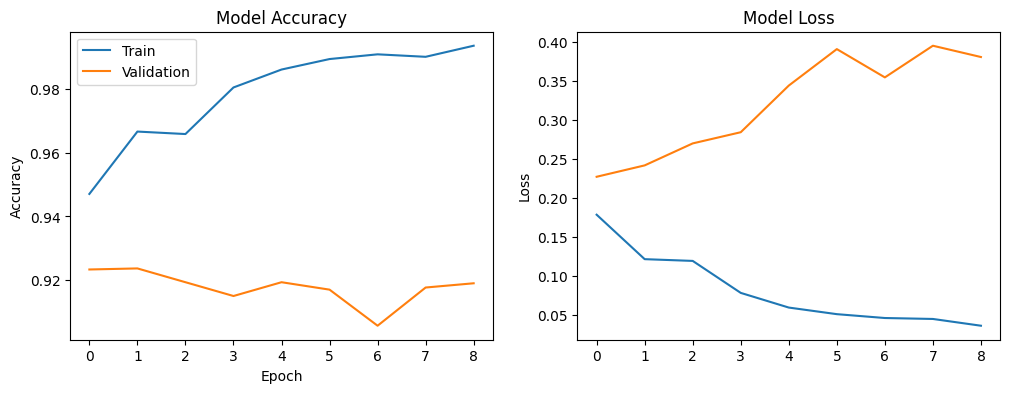

In [21]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')